<a href="https://colab.research.google.com/github/ashkanb77/polarity-detection/blob/main/polarity_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
from nltk.corpus import stopwords
from nltk import word_tokenize, download
from string import punctuation

In [ ]:
zipfile.ZipFile('data.zip').extractall('')

In [ ]:
download('stopwords')
download('punkt')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
neg_docs = []
neg_max = 0
for file_name in os.listdir('drive/MyDrive/data/neg'):
  with open('drive/MyDrive/data/neg/' + file_name) as file:
    txt = file.read()
    tokens = word_tokenize(txt)
    trans = str.maketrans('', '', punctuation)
    tokens = [w.translate(trans) for w in tokens if not w in stop_words]
    if len(tokens) > neg_max:
      neg_max = len(tokens)
    neg_docs.append(' '.join(tokens))
len(neg_docs)

1000

In [ ]:
pos_docs = []
pos_max = 0
for file_name in os.listdir('drive/MyDrive/data/pos'):
  with open('drive/MyDrive/data/pos/' + file_name) as file:
    txt = file.read()
    tokens = word_tokenize(txt)
    trans = str.maketrans('', '', punctuation)
    tokens = [w.translate(trans) for w in tokens if not w in stop_words]
    if len(tokens) > pos_max:
      pos_max = len(tokens)
    pos_docs.append(' '.join(tokens))
len(pos_docs)

1000

In [ ]:
import random
random.shuffle(pos_docs)
random.shuffle(neg_docs)

In [ ]:
X_train = neg_docs[:800] + pos_docs[:800]
y_train = [0 for _ in range(800)] + [1 for _ in range(800)]

In [ ]:
X_test = neg_docs[800:] + pos_docs[800:]
y_test = [0 for _ in range(200)] + [1 for _ in range(200)]

In [ ]:
max_len = max(pos_max, neg_max)

In [ ]:
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPool1D, Input, Embedding, concatenate


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train + X_test)

In [ ]:
with open('drive/MyDrive/data/tokenizer.h5', 'wb') as file:
  pickle.dump(tokenizer, file)

In [ ]:
# tokenizer.word_index

In [ ]:
with open('drive/MyDrive/data/tokenizer.h5', 'rb') as file:
  tokenizer = pickle.load(file)

In [ ]:
vocab_len = len(tokenizer.word_index) + 1
vocab_len

44897

In [ ]:
encoded = tokenizer.texts_to_sequences(X_train)
encoded_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
padded = pad_sequences(encoded, maxlen=max_len, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_len, padding='post')

In [ ]:
padded.shape

(1600, 1759)

In [ ]:
inp1 = Input(shape=(padded.shape[1], ))
embd1 = Embedding(vocab_len, 70)(inp1)
conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(embd1)
conv2 = Conv1D(filters=32, kernel_size=7, activation='relu')(embd1)
conv3 = Conv1D(filters=32, kernel_size=16, activation='relu')(embd1)

drop1 = Dropout(0.2)(conv1)
drop2 = Dropout(0.2)(conv2)
drop3 = Dropout(0.2)(conv3)

flat1 = Flatten()(drop1)
flat2 = Flatten()(drop2)
flat3 = Flatten()(drop3)

conc = concatenate([flat1, flat2, flat3])


dense1 = Dense(10, activation='relu')(conc)
output = Dense(1, activation='sigmoid')(dense1)

In [ ]:
model = Model(inputs=inp1, outputs=output)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1759)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1759, 70)     3142790     ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 1757, 32)     6752        ['embedding_2[0][0]']            
                                                                                                  
 conv1d_7 (Conv1D)              (None, 1753, 32)     15712       ['embedding_2[0][0]']            
                                                                                              

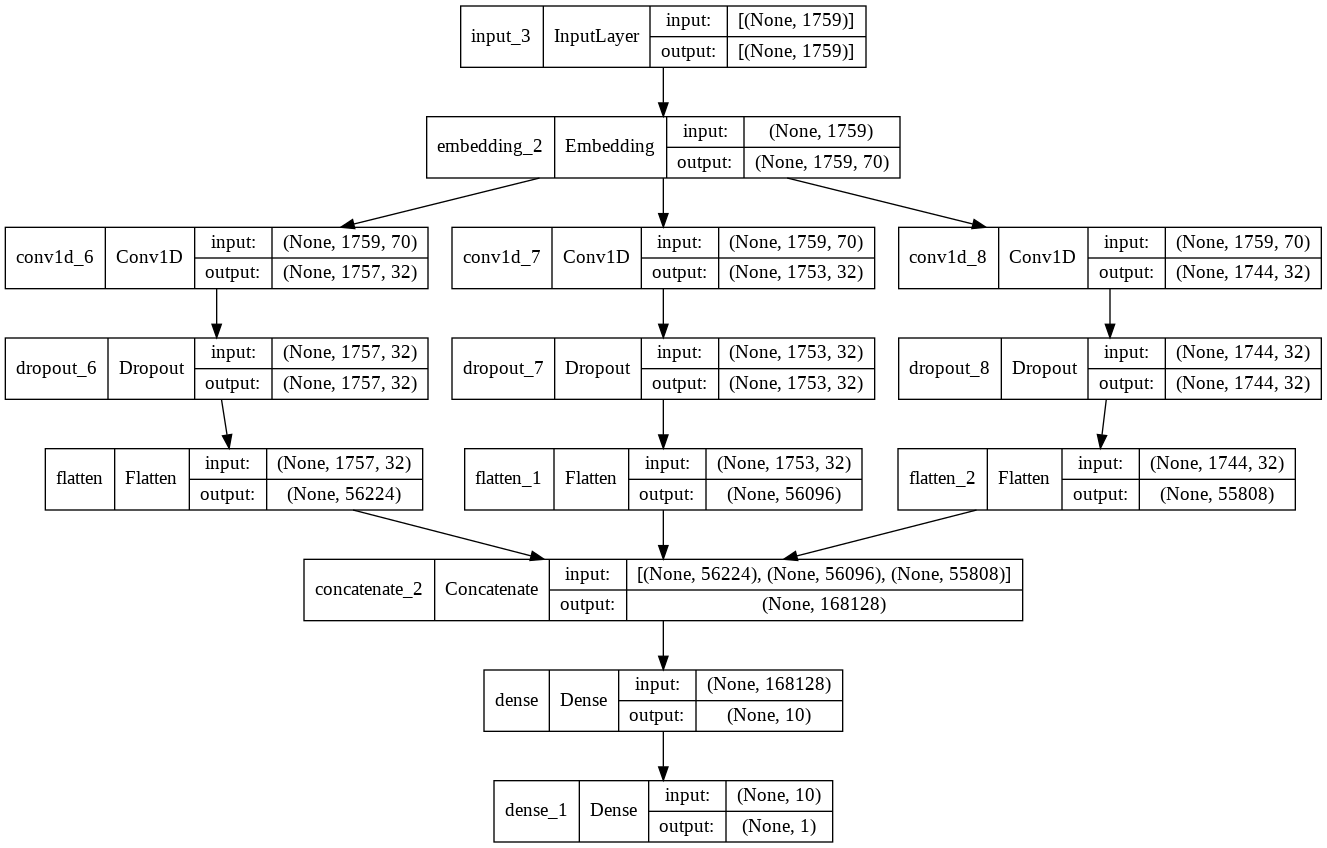

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
chp = ModelCheckpoint(
    'drive/MyDrive/data/polarity_model.h5', monitor='val_loss', 
    save_best_only=True, mode='min'
    )

erlstp = EarlyStopping(monitor='val_loss', patience=7, mode='min')

In [ ]:
hist = model.fit(
    padded, np.array(y_train), epochs=15, batch_size=30,
    validation_data=(padded_test, np.array(y_test)),
    callbacks=[chp, erlstp]
    )

Epoch 1/15
54/54 [==============================] - 39s 711ms/step - loss: 0.7016 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/15
54/54 [==============================] - 38s 700ms/step - loss: 0.6901 - accuracy: 0.5269 - val_loss: 0.6988 - val_accuracy: 0.5350
Epoch 3/15
54/54 [==============================] - 43s 797ms/step - loss: 0.4215 - accuracy: 0.8425 - val_loss: 0.4231 - val_accuracy: 0.8025
Epoch 4/15
54/54 [==============================] - 47s 865ms/step - loss: 0.0240 - accuracy: 0.9975 - val_loss: 0.3962 - val_accuracy: 0.8475
Epoch 5/15
54/54 [==============================] - 45s 830ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.3984 - val_accuracy: 0.8350
Epoch 6/15
54/54 [==============================] - 45s 823ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.4160 - val_accuracy: 0.8400
Epoch 7/15
54/54 [==============================] - 45s 829ms/step - loss: 0.0012 - accuracy: 0.9994 - val_loss: 0.4181 - val_accuracy: 0.8475